In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [1]:
import emcee
import sys
from astropy.table import Table
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import corner
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
"""Generate parameter constraints with emcee and Gaussian Processes."""

import emcee
import stats_utils
import numpy as np
import argparse

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import sem



In [5]:

class args:
    filename = 'noiseless.dat'
    data = 'PS'
    binmin = 300
    binmax = 5000
    mean_noise = 'K'
    cov_noise = 'K'
    redshift = ['05', '10', '15', '20', '25']
    smoothing_scale = '1.00'
    binscale = 'log'
    mcmc_N = 5000
    walkers = 64
    realizations = -1

In [6]:
print(f'filename: {args.filename}')
print(f'data source: {args.data}')
print(f'redshifts: {args.redshift}')
print(f'bin min, binmax: {args.binmin}, {args.binmax}')
print(f'mean noise: {args.mean_noise}, cov noise: {args.cov_noise}')
print(f'smoothing scale: {args.smoothing_scale}, binscale: {args.binscale}')
print(f'number of realizations: {args.realizations}')

gp_list = []
def build_GP(params, ell, ps_mean):
    """
    Build a function that interpolates using GP.

    Returns
    -------
        function which takes in cosmological parameters, outputs interpolation

    """
    global gp_list
    gp_list = []
    datascale = []  # normalize each bin so mean is 1
    for test_ell_bin in range(len(ell)):
        X = params
        X = np.atleast_2d(X).T
        y = np.array(
            [np.mean(ps_temp[:args.realizations, :], axis=0)[test_ell_bin]
                for ps_temp in ps_mean])
        dy = np.array(
            [sem(ps_temp[:args.realizations, :], axis=0)[test_ell_bin]
                for ps_temp in ps_mean])
        datascale.append(np.mean(y))
        y /= datascale[-1]
        dy /= datascale[-1]

        kernel = C(5.0, (1e-4, 1e4)) * RBF([3, 0.3, 5], (1e-4, 1e4))
        gp = GaussianProcessRegressor(kernel=kernel,
                                      alpha=(dy)**2,
                                      n_restarts_optimizer=50,
                                      normalize_y=True)
        gp.fit(X, y)
        gp_list.append(gp)

    datascale = np.array(datascale)

    def get_PS_(x):
        y_pred_list = []
        sigma_list = []
        for gp in gp_list:
            y_pred, sigma = gp.predict(np.atleast_2d(x), return_std=True)
            y_pred_list.append(y_pred[0])
            sigma_list.append(sigma[0])

        return np.array(y_pred_list * datascale),\
            np.array(sigma_list * datascale)

    return get_PS_


# load up a parameter table
params = np.array([stats_utils.table['M_nu(eV)'],
                   stats_utils.table['Omega_m'],
                   stats_utils.table['10^9*A_s']])

# stitch together the realizations from different redshifts
ell = []
ps_real = []
for redshift in args.redshift:
    ell_, ps_real_ = stats_utils.get_real_list(args.data,
                                               noisy=args.mean_noise,
                                               redshift=redshift,
                                               bin_min=args.binmin,
                                               bin_max=args.binmax,
                                               smoothing=args.smoothing_scale,
                                               binscale=args.binscale)
    del ps_real_[0]  # DELETE FID A
    ell.append(ell_)
    ps_real.append(ps_real_)

ell = np.hstack(ell)
ps_real = np.dstack(ps_real)

#  DELETE FID A
params = np.delete(params, 0, axis=1)

# load the inverse covariance, and then train the Gaussian Process
invcov = stats_utils.get_invcov(args.data,
                                noisy=args.cov_noise,
                                redshifts=args.redshift,
                                bin_min=args.binmin,
                                bin_max=args.binmax,
                                smoothing=args.smoothing_scale,
                                binscale=args.binscale)
fid = np.mean(ps_real[0], axis=0)  # FID1 is now INDEX 0
get_PS = build_GP(params, ell, ps_real)


filename: noiseless.dat
data source: PS
redshifts: ['05', '10', '15', '20', '25']
bin min, binmax: 300, 5000
mean noise: K, cov noise: K
smoothing scale: 1.00, binscale: log
number of realizations: -1
nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.36437146e-05,  2.45168371e-04, -5.13633113e-05, -9.17853213e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 19, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.21328262e-05, -5.35948214e-04,  2.17880053e-04,  9.66331668e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 106, 'nit': 36, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00067232, -0.00093842,  0.00352416,  0.00164396]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 

In [7]:

# set up some constants for prior evaluation
m_nu_min = 0.06  # minimum from oscillation experiments
m_nu_max = 2*np.max(stats_utils.table['M_nu(eV)'])
om_m_min = np.min(stats_utils.table['Omega_m'])
om_m_max = 2*np.max(stats_utils.table['Omega_m'])
A_s_min = np.min(stats_utils.table['10^9*A_s'])
A_s_max = 2*np.max(stats_utils.table['10^9*A_s'])


# define emcee function calls, prior, likelihood,
def lnprior(theta):
    """Ensure the sampler stays near computed simulations."""
    m_nu, om_m, A_s = theta
    if (m_nu_min < m_nu < m_nu_max and
            om_m_min < om_m < om_m_max and
            A_s_min < A_s < A_s_max):
        return 0.0
    return -np.inf


def lnlike(theta):
    """Compute the log likelihood based on multivariate Gaussian."""
    model, sig = get_PS(theta)
    dmu = fid - model
    return -0.5 * (np.dot(dmu, np.dot(invcov, dmu)))


def lnprob(theta):
    """Combine the likelihood and prior."""
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)


# set up emcee
ndim, nwalkers = 3, args.walkers
p0 = [params.T[0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)


In [ ]:

# set up emcee
ndim, nwalkers = 3, args.walkers
p0 = [params.T[0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)


# begin sampling, use incremental chain
filename = args.filename
f = open(filename, "w")
f.close()

for result in sampler.sample(p0, iterations=args.mcmc_N, storechain=False):
    position = result[0]
    f = open(filename, "a")
    for k in range(position.shape[0]):
        out_str = "{0:4d} {1:s}\n".format(k, ' '.join(map(str, position[k])))
        f.write(out_str)
    f.close()


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


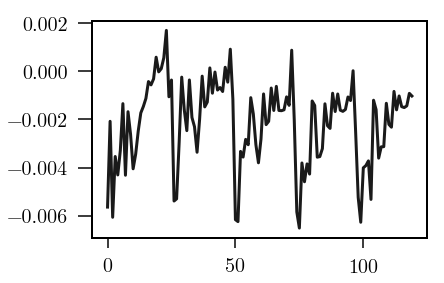

In [15]:
ys, sigmas = get_PS( np.array([0.22515023, 0.30164661, 2.22368606]) )
plt.plot( (ys - fid)/fid)

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


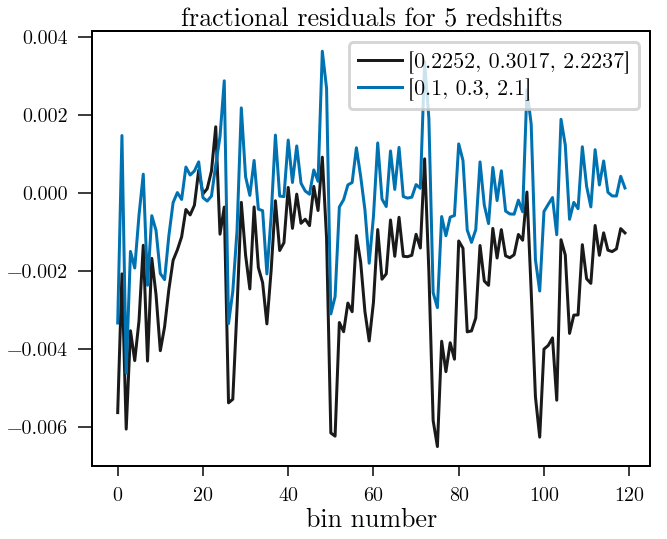

In [30]:
plt.figure(figsize=(10,8))

ys, sigmas = get_PS( np.array([0.22515023, 0.30164661, 2.22368606]) )
ys_0, sigmas_0 = get_PS( np.array([0.1, 0.3, 2.1]) )
plt.plot( (ys - fid)/fid, label = '[0.2252, 0.3017, 2.2237]')
plt.plot( (ys_0 - fid)/fid, label='[0.1, 0.3, 2.1]' )
plt.title('fractional residuals for 5 redshifts')
plt.xlabel(r'bin number')
plt.legend(frameon=True)

In [12]:
stats_utils.table

Model,M_nu(eV),Omega_m,10^9*A_s,sigma_8(derived),filename
str12,float64,float64,float64,float64,str72
1a(fiducial),0.0,0.3,2.1,0.8523,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995
1b(fiducial),0.1,0.3,2.1,0.8295,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995
2,0.06271,0.3815,2.2004,1.0135,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841
3,0.06522,0.2821,1.8826,0.7563,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790
4,0.06773,0.4159,1.6231,0.9171,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404
5,0.07024,0.2023,2.3075,0.6231,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760
6,0.07275,0.3283,2.2883,0.9324,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169
7,0.07526,0.3355,1.5659,0.7828,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444
8,0.07778,0.2597,2.4333,0.8008,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029
